# Import Library

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import PartialDependenceDisplay
import geopandas as gpd
import contextily as ctx
from sklearn.model_selection import cross_val_score

# Load Dataset

In [4]:
# Load dataset
california = fetch_california_housing()
X = pd.DataFrame(california.data, columns=california.feature_names)
y = california.target

# EDA

In [5]:
# 1.1 Data structure
print(X.head())
print("\nMissing values:\n", X.isnull().sum())
print("\nDescriptive stats:\n", X.describe())

   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  
0    -122.23  
1    -122.22  
2    -122.24  
3    -122.25  
4    -122.25  

Missing values:
 MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64

Descriptive stats:
              MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558   

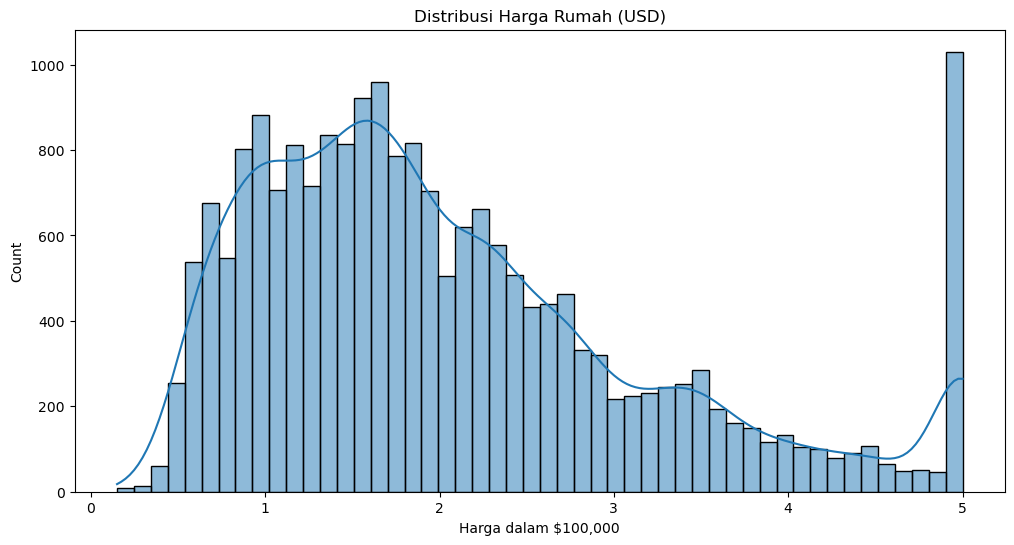

In [6]:
# 1.2 Target distribution
plt.figure(figsize=(12, 6))
sns.histplot(y, bins=50, kde=True)
plt.title("Distribusi Harga Rumah (USD)")
plt.xlabel("Harga dalam $100,000")
plt.show()

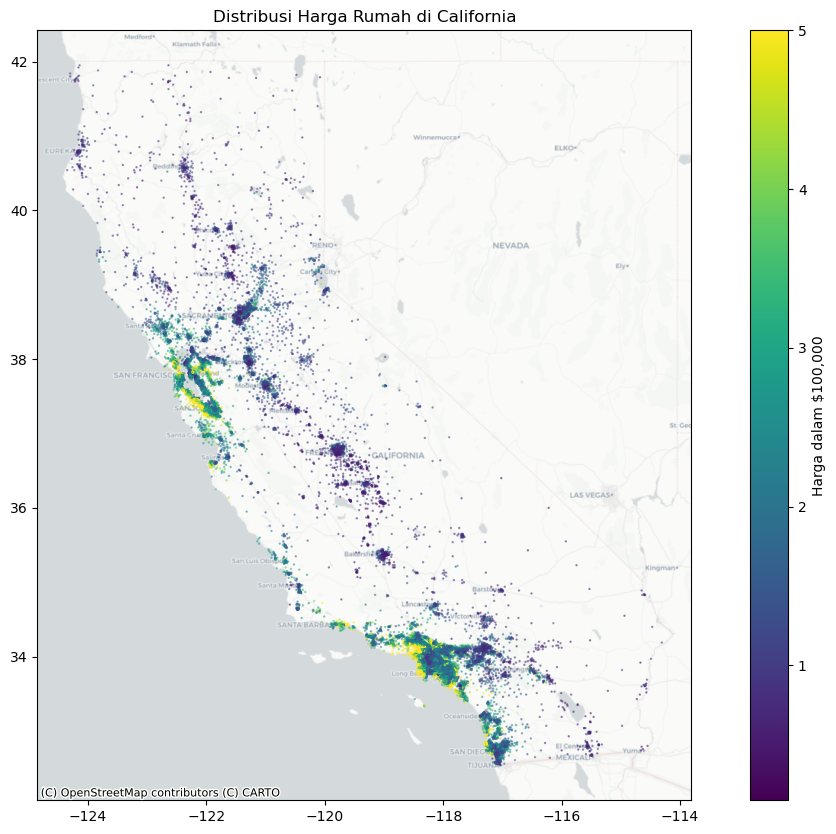

In [8]:
# 1.3 Geospatial analysis

df_geo = pd.DataFrame(X, columns=california.feature_names)
df_geo['MedHouseVal'] = y

# Buat GeoDataFrame
gdf = gpd.GeoDataFrame(
    df_geo, 
    geometry=gpd.points_from_xy(df_geo.Longitude, df_geo.Latitude)
)
gdf = gdf.set_crs(epsg=4326)

# Plot
fig, ax = plt.subplots(figsize=(15, 10))
gdf.plot(
    ax=ax, 
    markersize=0.5, 
    alpha=0.5, 
    column='MedHouseVal', 
    cmap='viridis', 
    legend=True,
    legend_kwds={'label': "Harga dalam $100,000"}
)
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)
plt.title("Distribusi Harga Rumah di California")
plt.show()

<Figure size 1200x800 with 0 Axes>

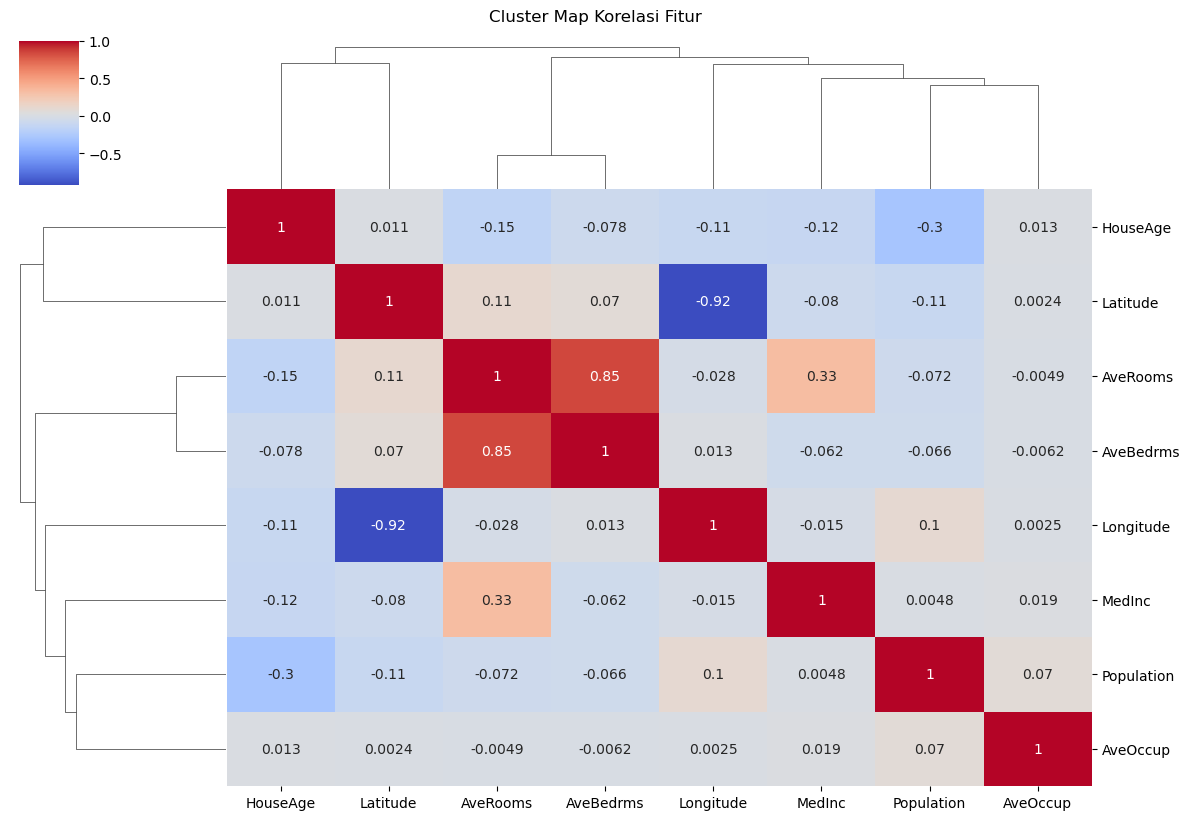

In [9]:
# 1.4 Correlation matrix with cluster map
plt.figure(figsize=(12, 8))
sns.clustermap(X.corr(), annot=True, cmap='coolwarm', figsize=(12, 8))
plt.suptitle("Cluster Map Korelasi Fitur", y=1.02)
plt.show()

c:\Users\rifal\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


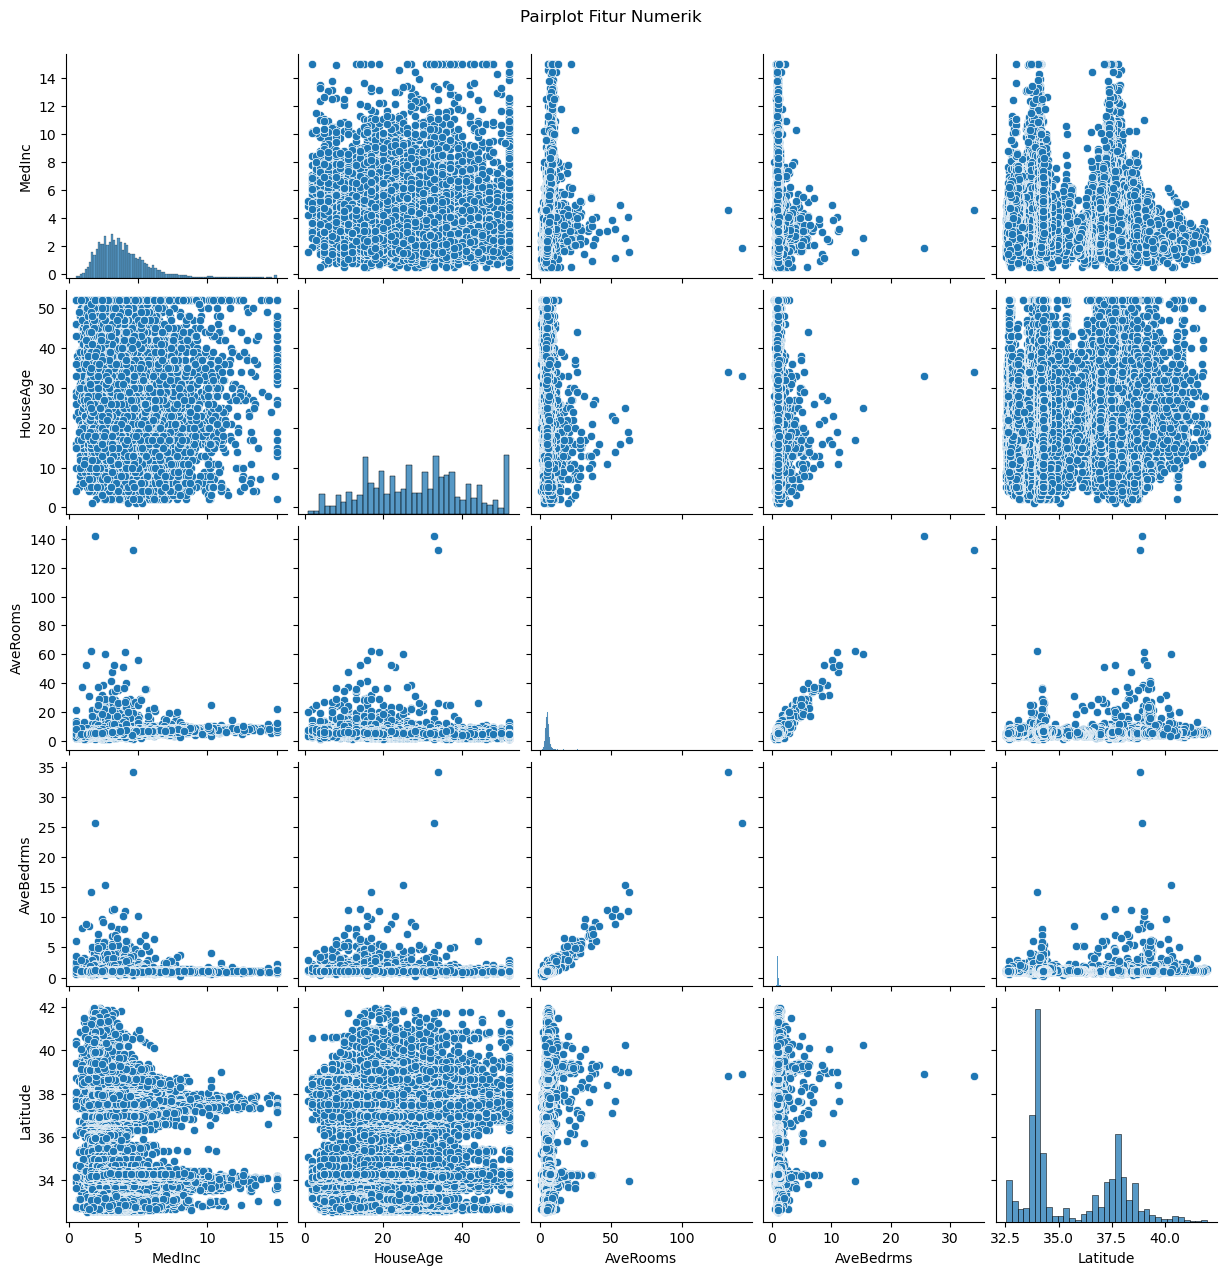

In [10]:
# 1.5 Pairplot untuk fitur penting
sns.pairplot(X[['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Latitude']])
plt.suptitle("Pairplot Fitur Numerik", y=1.02)
plt.show()

# Preprocessing

In [11]:
# 2.1 Train-test split dengan stratification
bins = np.quantile(y, [0, 0.25, 0.5, 0.75, 1.0])
y_binned = np.digitize(y, bins)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y_binned, random_state=42
)

In [12]:
# 2.2 Pipeline preprocessing
preprocessor = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree=2, include_bias=False)
)

X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.transform(X_test)

# Modelling

In [13]:
# 3.1 Definisi model & parameter grid
models = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(random_state=42),
    'Lasso': Lasso(random_state=42),
    'ElasticNet': ElasticNet(random_state=42)
}

params = {
    'Ridge': {'alpha': np.logspace(-3, 3, 100)},
    'Lasso': {'alpha': np.logspace(-3, 3, 100)},
    'ElasticNet': {
        'alpha': np.logspace(-3, 3, 50),
        'l1_ratio': np.linspace(0.1, 0.9, 50)
    }
}

In [14]:
# 3.2 Training dengan RandomizedSearchCV
results = {}
for name in models:
    if name in params:
        model = RandomizedSearchCV(
            models[name], 
            params[name], 
            n_iter=100,
            cv=5, 
            scoring='neg_mean_squared_error',
            random_state=42
        )
    else:
        model = models[name]
    
    model.fit(X_train_trans, y_train)
    
    # Simpan hasil
    if hasattr(model, 'best_params_'):
        best_params = model.best_params_
        best_model = model.best_estimator_
    else:
        best_params = None
        best_model = model
    
    y_pred = best_model.predict(X_test_trans)
    
    results[name] = {
        'model': best_model,
        'params': best_params,
        'mae': mean_absolute_error(y_test, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
        'r2': r2_score(y_test, y_pred)
    }

c:\Users\rifal\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.009e+03, tolerance: 1.760e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\rifal\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.691e+03, tolerance: 1.775e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\rifal\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.880e+03, toleranc

# Evaluasi

In [15]:
# 4.1 Tabel perbandingan metrik
metrics_df = pd.DataFrame({
    'Model': results.keys(),
    'MAE': [results[name]['mae'] for name in results],
    'RMSE': [results[name]['rmse'] for name in results],
    'R²': [results[name]['r2'] for name in results]
}).set_index('Model')

print("\nPerformance Comparison:")
print(metrics_df.sort_values('RMSE'))


Performance Comparison:
                 MAE      RMSE        R²
Model                                   
Ridge       0.529459  0.722675  0.606848
Lasso       0.538176  0.727554  0.601521
ElasticNet  0.546125  0.737871  0.590139
Linear      0.518063  2.840018 -5.071796


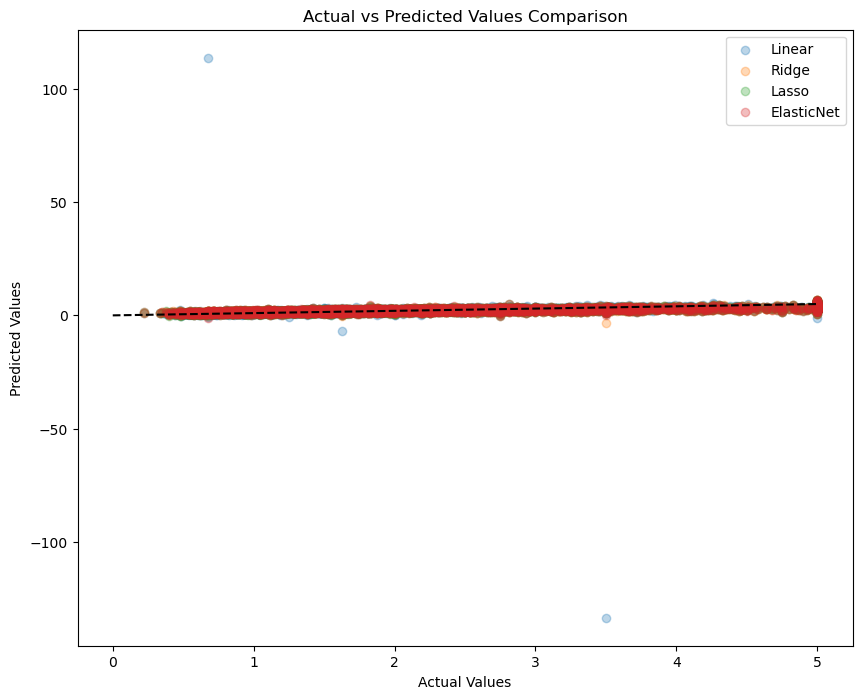

In [16]:
# 4.2 Actual vs Predicted plot
plt.figure(figsize=(10, 8))
for name in results:
    y_pred = results[name]['model'].predict(X_test_trans)
    plt.scatter(y_test, y_pred, alpha=0.3, label=name)
    
plt.plot([0, 5], [0, 5], 'k--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values Comparison")
plt.legend()
plt.show()

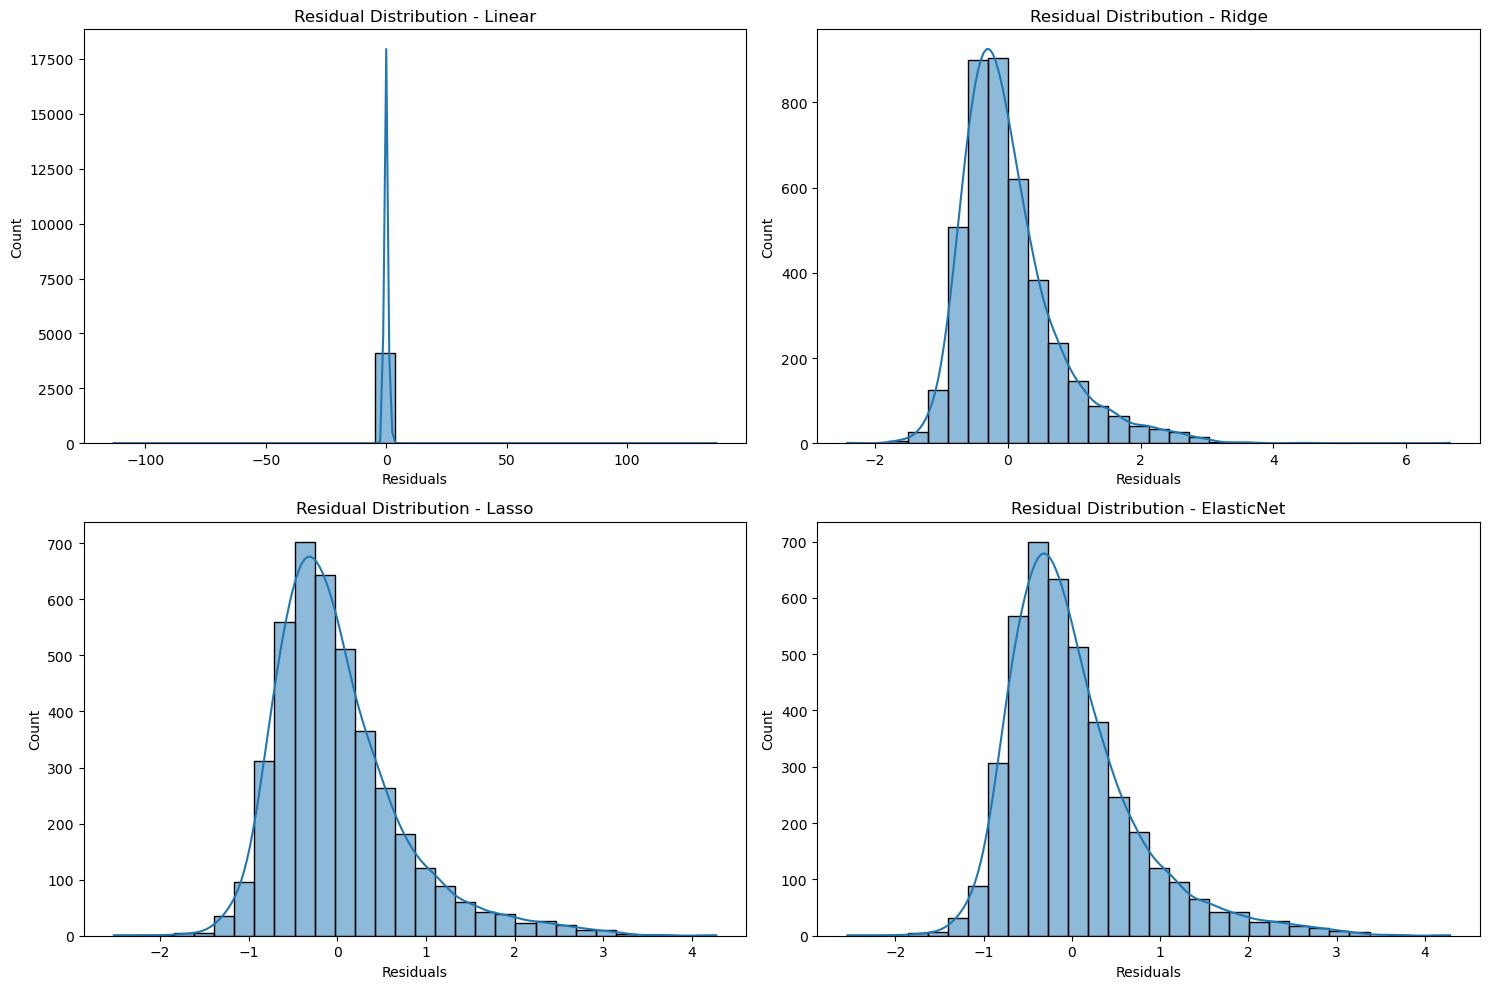

In [17]:
# 4.3 Residual analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
for ax, name in zip(axes.flatten(), results):
    y_pred = results[name]['model'].predict(X_test_trans)
    residuals = y_test - y_pred
    sns.histplot(residuals, kde=True, ax=ax, bins=30)
    ax.set_title(f"Residual Distribution - {name}")
    ax.set_xlabel("Residuals")
plt.tight_layout()
plt.show()

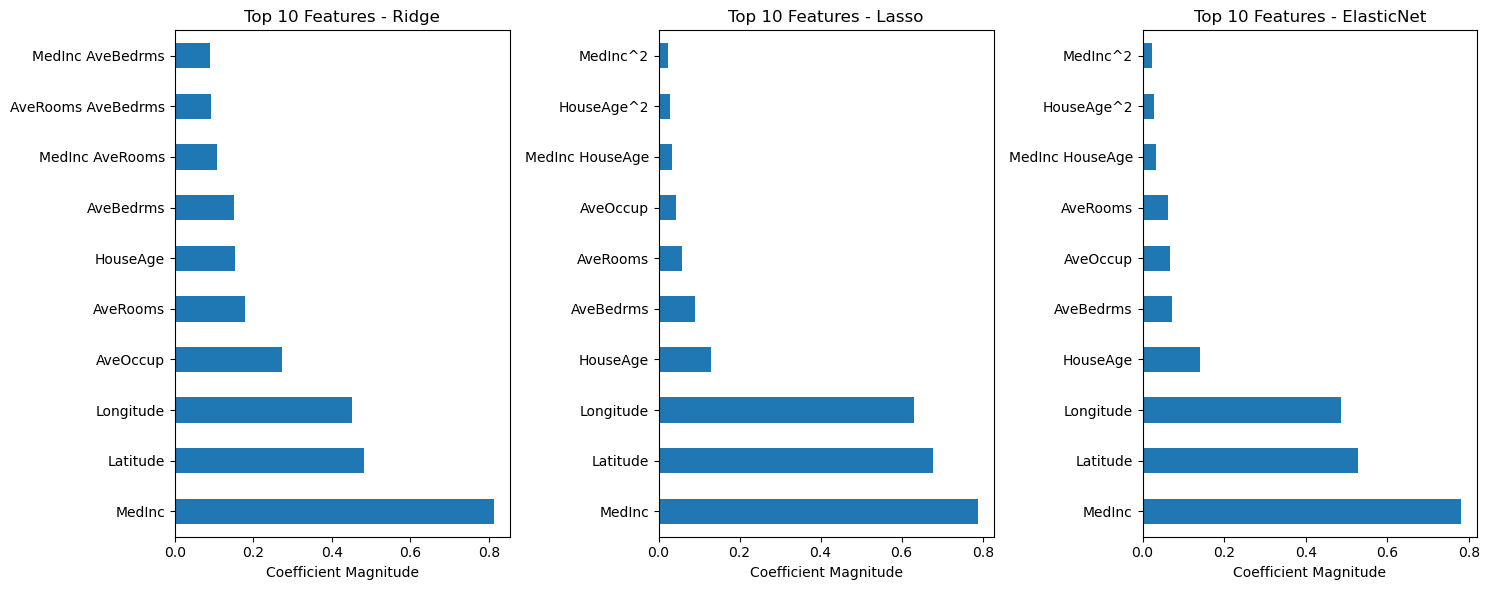

In [18]:
# 4.4 Feature importance untuk model regularized
plt.figure(figsize=(15, 6))
for i, name in enumerate(['Ridge', 'Lasso', 'ElasticNet'], 1):
    plt.subplot(1, 3, i)
    coef = results[name]['model'].coef_
    important_features = pd.Series(coef, index=preprocessor.get_feature_names_out())
    important_features.abs().sort_values(ascending=False).head(10).plot(kind='barh')
    plt.title(f"Top 10 Features - {name}")
    plt.xlabel("Coefficient Magnitude")
plt.tight_layout()
plt.show()

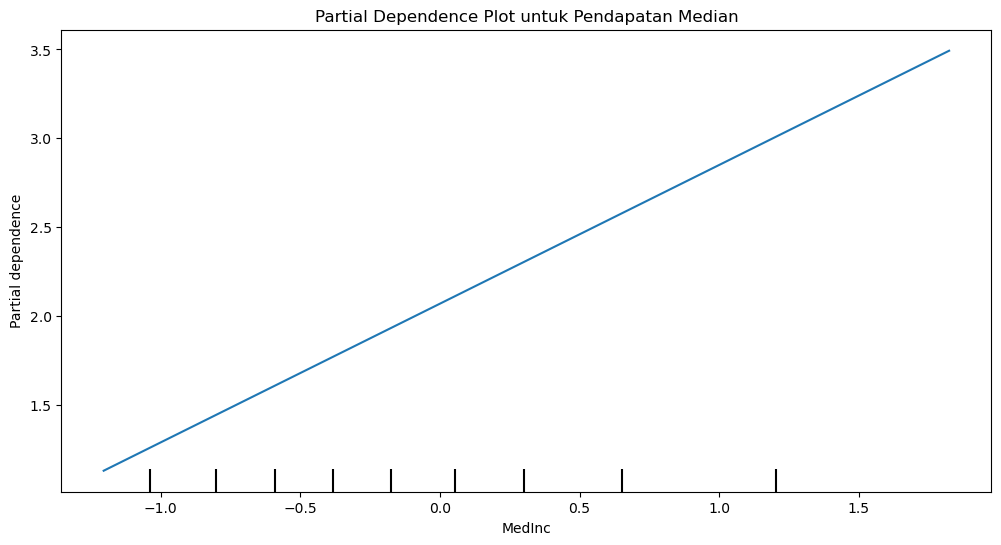

In [19]:
# 4.5 Partial dependence plot
plt.figure(figsize=(12, 6))
ax = plt.gca()

# Cari index fitur 'MedInc' dalam nama fitur yang sudah diproses
feature_idx = np.where(preprocessor.get_feature_names_out() == 'MedInc')[0][0]

PartialDependenceDisplay.from_estimator(
    results['ElasticNet']['model'], 
    X_train_trans, 
    features=[feature_idx],
    feature_names=preprocessor.get_feature_names_out(),
    ax=ax
)

plt.title("Partial Dependence Plot untuk Pendapatan Median")
plt.show()

# Interpretasi Model

In [22]:
# 5.1 Cross-validated performance
final_model = results['ElasticNet']['model']
cv_scores = cross_val_score(
    final_model, 
    X_train_trans, 
    y_train, 
    cv=10, 
    scoring='neg_root_mean_squared_error'
)
print(f"Cross-Validated RMSE: {-cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

c:\Users\rifal\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.135e+01, tolerance: 1.970e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\rifal\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.305e+02, tolerance: 1.990e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\rifal\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.681e+01, toleranc

Cross-Validated RMSE: 0.743 ± 0.031


c:\Users\rifal\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.544e+02, tolerance: 1.956e+00
  model = cd_fast.enet_coordinate_descent(


In [23]:
# 5.2 Persamaan model terbaik
coef_df = pd.DataFrame({
    'Feature': preprocessor.get_feature_names_out(),
    'Coefficient': final_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print("\nModel Equation:")
print("MedHouseVal = ")
for _, row in coef_df.iterrows():
    print(f"{row['Coefficient']:.4f} * {row['Feature']} +")
print(f"{final_model.intercept_:.4f}")


Model Equation:
MedHouseVal = 
0.7813 * MedInc +
-0.5281 * Latitude +
-0.4863 * Longitude +
0.1397 * HouseAge +
0.0734 * AveBedrms +
-0.0681 * AveOccup +
-0.0613 * AveRooms +
0.0321 * MedInc HouseAge +
0.0284 * HouseAge^2 +
-0.0227 * MedInc^2 +
-0.0097 * Latitude^2 +
0.0077 * AveRooms^2 +
0.0077 * MedInc AveRooms +
-0.0058 * AveRooms AveBedrms +
0.0037 * HouseAge Population +
0.0027 * Population Latitude +
0.0011 * MedInc Population +
-0.0005 * AveBedrms^2 +
0.0003 * AveOccup^2 +
0.0000 * Population^2 +
0.0000 * AveBedrms AveOccup +
0.0000 * AveBedrms Longitude +
0.0000 * AveBedrms Latitude +
0.0000 * AveOccup Latitude +
0.0000 * Population AveOccup +
-0.0000 * Population Longitude +
-0.0000 * AveOccup Longitude +
0.0000 * Latitude Longitude +
-0.0000 * AveBedrms Population +
-0.0000 * HouseAge Longitude +
-0.0000 * AveRooms Longitude +
0.0000 * AveRooms Latitude +
0.0000 * AveRooms AveOccup +
-0.0000 * AveRooms Population +
-0.0000 * HouseAge Latitude +
-0.0000 * HouseAge AveOccup +
